In [62]:
import numpy as np 
import pandas as pd
import os 
import sys
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
from grid_strategy import strategies

In [63]:
wd = os.getcwd()
root = os.path.dirname(wd)


with open(os.path.join(root, 'data/processed/perfusion_data_cleaned.csv')) as data_file:    
    data = pd.read_csv(data_file)

 remove data from some runs that are empty due to flaws in the material 

In [64]:
data = data.drop(data[data.Run.isin([10, 11, 12, 13, 14])].index)

# Explore Variables

In [65]:
with open(os.path.join(root, 'data/processed/metadata.json')) as data_file:    
    schema = json.load(data_file)

## Univariate Analysis

In [66]:
# get numerical variables that are output

def get_vars(col, data):
    pattern = re.compile(rf"^{re.escape(col)}_D-\d+$")
    return [
        col for col in data.columns
        if pattern.match(col)
    ]
    
numerical_vars = []
for col, col_info in schema.items():
    if col_info["type"] in ("float", "Int64") and col_info["role"] == "output":
        if col_info["time_dependent"] == True:
            cols = get_vars(col, data)
            numerical_vars.extend(cols)
        else:
            numerical_vars.append(col)


there are no categorical output variables 

In [84]:
#get input variables 
input_vars = []
for col, col_info in schema.items():
    if col_info["role"] == "condition":
        if col_info["time_dependent"] == True:
            cols = get_vars(col, data)
            input_vars.extend(cols)
        else:
            input_vars.append(col)

print(input_vars)

['Date', 'Run', 'Donor', 'Static_run', 'AMBR15_run', 'Conditions', 'Agitation_Strategy', 'System', 'Agitation', 'Activation_reagent', 'Activation_time', 'Cells_per_Microbeads', 'DO_activation', 'DO_expansion', 'Cytokine_supplementation', 'Inoculum', 'Type']


In [90]:
#get unique values for input variables
for var in input_vars:
    try:
        print(var, np.unique(data[var].astype(str)))
    except:
        raise ValueError(f"Variable {var} not found in data.")

Date ['2023-04-10 to 2023-04-21' '2023-05-15 to 2023-05-30'
 '2023-06-27 to 2023-07-07' '2023-07-18 to 2023-07-28'
 '2023-08-22 to 2023-09-01' '2024-01-08 to 2024-01-19'
 '2024-02-20 to 2024-03-01' '2024-04-08 to 2024-04-19'
 '2024-08-13 to 2024-08-23']
Run ['1' '2' '3' '4' '5' '6' '7' '8' '9']
Donor ['1' '10' '14' '15' '2' '3' '6' '7' '8']
Static_run ['No' 'Yes' 'Yes (24-wp)' 'Yes 24-well' 'Yes 48-well']
AMBR15_run ['No' 'Yes Working volume: 10mL' 'Yes Working volume: 12mL']
Conditions ['Continuous vs Intermittent'
 'DO (15% vs 60% during activation); cell/uC ratio' 'DO=60%; pH=7.4'
 'Reduce cell/mL to 2M when needed;'
 'Start ME daily on D5 of culture; Twice on D6 onwards'
 'Start ME daily on D6 of culture'
 'Start ME daily on Day 6 of culture only;'
 'TexMACS vs Optimizer - Continuous agitation; Start ME daily on Day 6 of culture only; Twice only on day 8 onwards'
 'TexMACS; DO=60%; pH=7.3' 'TexMACS; uCs until D3 - 800 uC / cell'
 'TexMACS; uCs until D3 vs D14;' 'Twice on D6 onwards

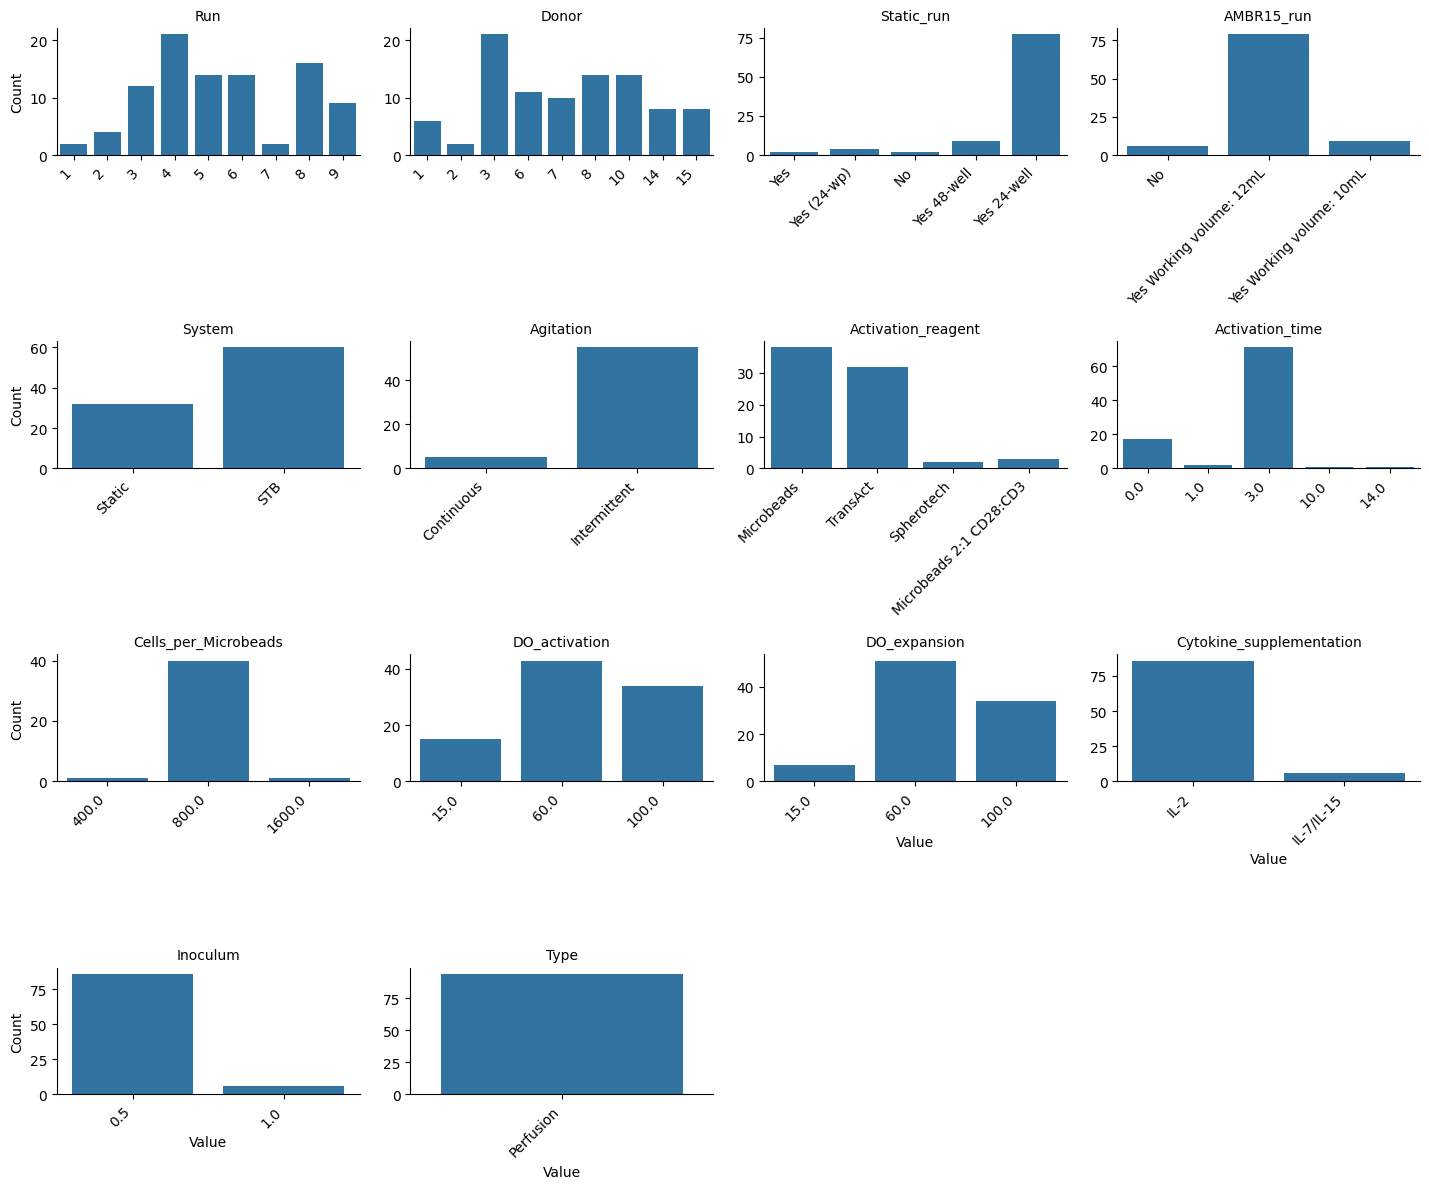

In [108]:
# Create a new list excluding all elements in `elements_to_remove`
elements_to_remove = ['Conditions', 'Date', 'Agitation_Strategy']
input_vars_to_plot = [item for item in input_vars if item not in elements_to_remove]

# Reshape your data for FacetGrid
plot_data = pd.melt(data[input_vars_to_plot], var_name='Variable', value_name='Value')

# Create FacetGrid
g = sns.FacetGrid(plot_data, col='Variable', col_wrap=4, height=3, aspect=1.2,
                  sharex=False, sharey=False)

# Map countplot to each facet
g.map_dataframe(sns.countplot, x='Value')

# Adjust titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Count")

# Rotate x-axis labels for better readability
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to accommodate rotated labels
g.tight_layout()

I think the variables AMBR15 run and static run are misleading should check the system variabl. 

In [67]:
data_numerical = data[numerical_vars]
data_numerical.describe()

,VCD_D-0,VCD_D-1,VCD_D-3,VCD_D-5,VCD_D-6,VCD_D-7,VCD_D-9,VCD_D-10,Viability_D-3,Viability_D-7,...,TNF-a_D-3,TNF-a_D-7,TNF-a_D-10,IFN-y_TNF-a_D-3,IFN-y_TNF-a_D-7,IFN-y_TNF-a_D-10,CD4_CD8_ratio_D-0,CD4_CD8_ratio_D-3,CD4_CD8_ratio_D-7,CD4_CD8_ratio_D-10
count,94.000000,73.000000,8.300000e+01,7.000000e+01,7.800000e+01,8.800000e+01,1.200000e+01,8.900000e+01,87.000000,91.000000,...,14.000000,35.000000,38.000000,14.000000,33.000000,34.000000,52.000000,69.000000,69.000000,71.000000
mean,537234.042553,428032.534247,4.241702e+05,1.031458e+06,2.483958e+06,4.238683e+06,6.636693e+06,1.089432e+07,79.553548,85.437174,...,55.750000,76.057143,83.326316,19.600000,20.832121,26.761765,1.921538,2.240146,1.489436,1.238257
std,131969.402248,83197.245723,2.588914e+05,7.782614e+05,1.954979e+06,3.931412e+06,5.630458e+06,1.080925e+07,15.991966,17.348559,...,12.985954,16.821263,10.016114,3.665851,8.970151,10.955807,0.267152,0.430950,0.961835,1.479121
min,500000.000000,246875.000000,1.093750e+05,1.880000e+05,9.000000e+04,6.625000e+04,8.703125e+05,2.125000e+04,0.758427,0.939850,...,37.800000,28.800000,45.200000,12.700000,5.300000,4.300000,1.590000,1.650000,0.470000,0.275953
25%,500000.000000,371250.000000,2.859375e+05,4.403438e+05,8.915312e+05,7.105833e+05,2.322500e+06,2.062500e+06,74.125000,82.835000,...,44.200000,71.650000,83.575000,16.525000,15.800000,20.000000,1.670000,1.919505,0.754919,0.365000
50%,500000.000000,431250.000000,3.750000e+05,8.015625e+05,2.015000e+06,2.868750e+06,4.765000e+06,6.437500e+06,83.435583,92.360000,...,57.500000,80.100000,85.550000,20.500000,20.800000,23.850000,2.020000,2.140000,1.260000,0.770000
75%,500000.000000,478750.000000,4.656250e+05,1.456875e+06,3.885938e+06,6.706875e+06,1.160000e+07,2.120000e+07,88.750000,95.790000,...,65.600000,88.350000,88.900000,22.825000,26.600000,33.325000,2.070000,2.413428,1.870662,1.403010
max,1000000.000000,630000.000000,1.710000e+06,4.225000e+06,7.230000e+06,1.790000e+07,1.790000e+07,3.712500e+07,97.617896,99.100000,...,79.300000,93.500000,94.900000,23.800000,41.900000,50.200000,2.360000,3.650000,4.880000,8.070000


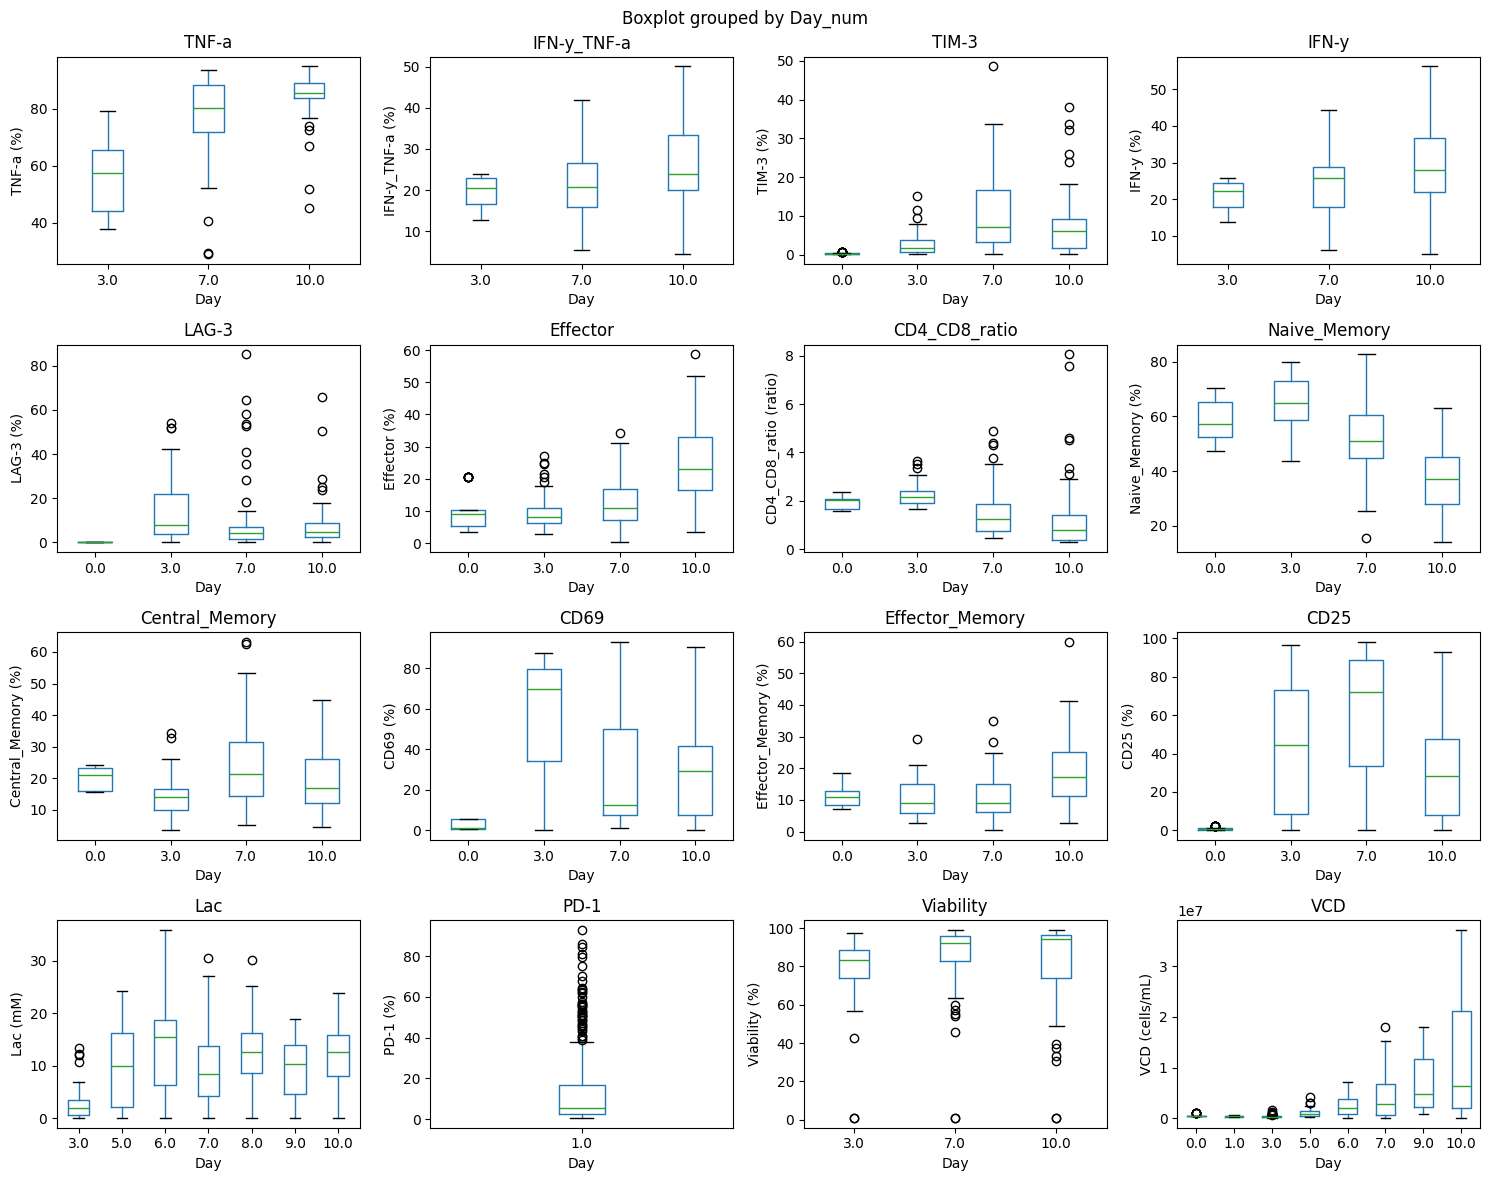

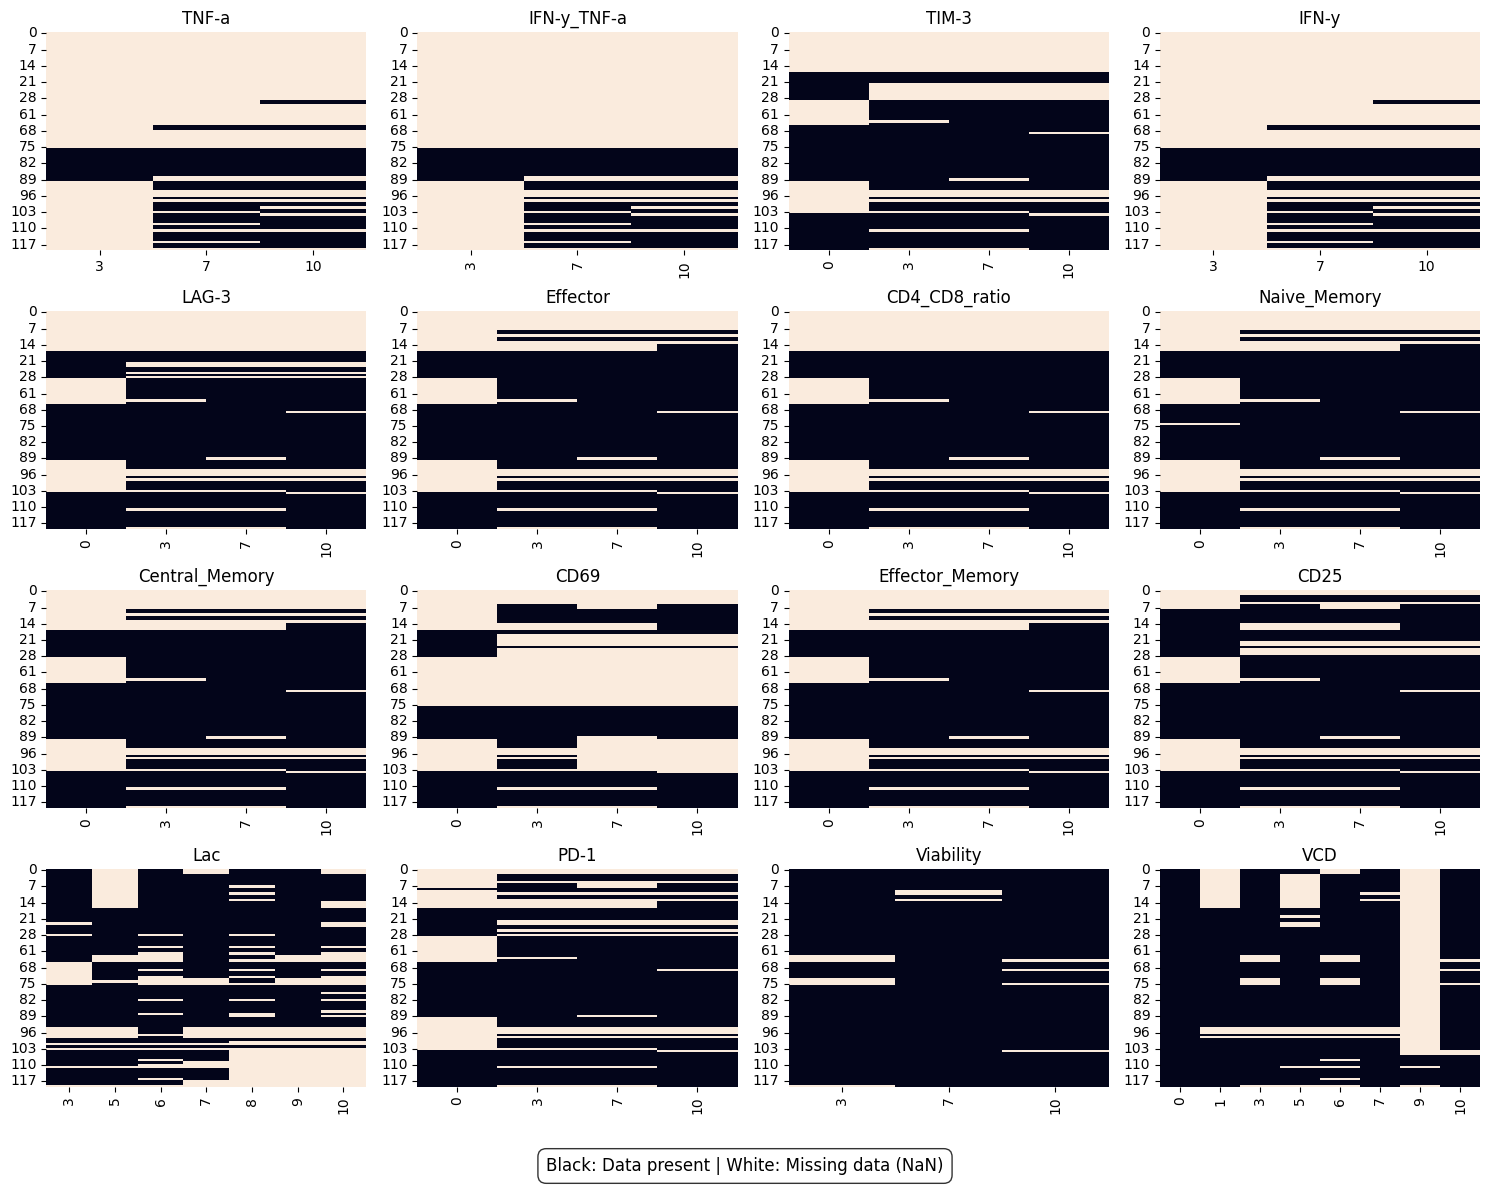

In [74]:

# Step 1 — Extract all variable prefixes that match `XYZ_D-<number>`
pattern = re.compile(r"^(.+)_D-\d+$")

# Collect all base names (e.g., 'VCD', 'Viability')
variable_prefixes = set()

for col in data.columns:
    match = pattern.match(col)
    if match:
        variable_prefixes.add(match.group(1))  # Extract 'VCD' from 'VCD_D-1'


fig_boxplot, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
fig_nan, axs_nan = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))

# Step 2 — Loop over each variable prefix and plot
for var, ax, ax_nan in zip(variable_prefixes, axs.flatten(), axs_nan.flatten()):

    # Find all matching columns for this variable
    matching_cols = [col for col in data.columns if col.startswith(f"{var}_D-")]

    # Check if variable exists in schema and get its unit
    if var in schema:
        unit = schema[var]["unit"]
    else:
        unit = "unknown"

    # Plot Boxplot
    df_long = data[matching_cols].melt(var_name="Day", value_name=var)

    # Extract numeric day for sorting
    df_long["Day_num"] = df_long["Day"].str.extract(r'D-(\d+)').astype(float)

    # Plot    
    df_long.boxplot(by="Day_num", column=var, ax = ax, grid=False)
    
    # plt.suptitle("")
    ax.set_xlabel("Day")
    ax.set_ylabel(f"{var} ({unit})")

    ## Plot Nan 
    sns.heatmap(data[matching_cols].isna(), ax=ax_nan, cbar=False)
     # Set the title for the heatmap
    ax_nan.set_title(var)
    
    # Extract day numbers from column names
    day_numbers = [col.split('_D-')[1] for col in matching_cols]
    
    # Set x-tick labels to just the day numbers
    ax_nan.set_xticklabels(day_numbers)

fig_boxplot.tight_layout()
fig_nan.tight_layout()
# Add a legend/caption for the heatmap colors
fig_nan.subplots_adjust(bottom=0.09)  # Make room for the caption
caption_text = "Black: Data present | White: Missing data (NaN)"
fig_nan.text(0.5, 0.02, caption_text, ha='center', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

fig_boxplot.savefig(os.path.join(root, 'reports/figures/EDA_boxplot_outputs.png'), dpi=300)
fig_nan.savefig(os.path.join(root, 'reports/figures/EDA_missing_values_ouputs.png'), dpi=300)

these are the plots of all the data, should create plots with more recent, more robust data.
Nonetheless, it seems that there is a large data dispersion, possibily due to the mixing of STB and shake flask data. there is not extreme data missing, but I am not sure if good data imputation is easy to do in bioprocessing -> check literature

I did plots of boxplot for STB and shake flask data separately, the data was very dispersed, a lot of dots, this might also be due to not existing enough data. 